<img src="https://raw.githubusercontent.com/imgremlin/Photos/master/electricity.jpg" width="1000px"> 
# Fraud Detection in Electricity and Gas Consumption Challenge
**by team GORNYAKI (Tsepa Oleksii and Samoshin Andriy [Ukraine, KPI, IASA])**

Thanks to the organizers for this [challenge](https://zindi.africa/competitions/ai-hack-tunisia-4-predictive-analytics-challenge-1) and everyone for participating! In this notebook you will find:

* importing libraries
* basic EDA
* feature engeneering
* modelling
* prediction 
* submission

<h2>Importing libraries</h2>

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

seed=47

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/client_train.csv
/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/client_test.csv
/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/invoice_test.csv
/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/SampleSubmission (2).csv
/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/invoice_train.csv


In [63]:
invoice_test = pd.read_csv('/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/invoice_test.csv',low_memory=False)
invoice_train = pd.read_csv('/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/invoice_train.csv',low_memory=False)
client_test = pd.read_csv('/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/client_test.csv',low_memory=False)
client_train = pd.read_csv('/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/client_train.csv',low_memory=False)
sample_submission = pd.read_csv('/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/SampleSubmission (2).csv',low_memory=False)

<h2>Basic EDA</h2>

We won't show full EDA, just want to attract your attention to tips which help us to reach good score.

In next two cells you will find value counts according each column in train and test set. This information we'll use in feature engeneering  

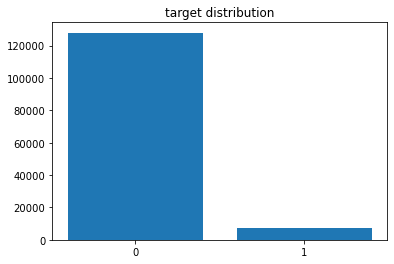

In [64]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

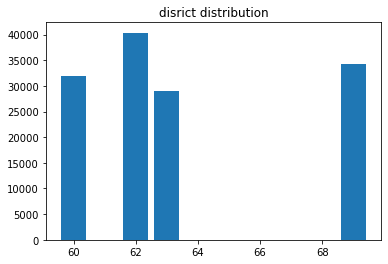

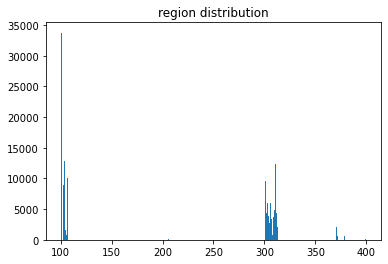

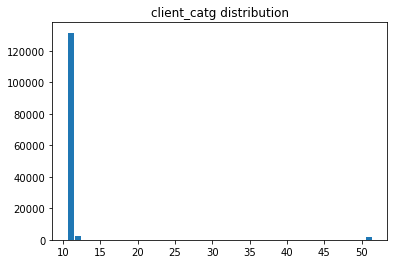

In [65]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [66]:
print('Number of missing rows in invoice_train:',invoice_train.isna().sum().sum())
print('Number of missing rows in invoice_test:',invoice_test.isna().sum().sum(),'\n')
print('Number of missing rows in client_train:',client_train.isna().sum().sum())
print('Number of missing rows in client_test:',client_test.isna().sum().sum())

Number of missing rows in invoice_train: 0
Number of missing rows in invoice_test: 0 

Number of missing rows in client_train: 0
Number of missing rows in client_test: 0


In [67]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


<h2>Feature engeneering</h2>

In this part we want to explain the most powerful decision in our notebook - feature creation

In [68]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

* 'client_catg', 'district' and 'region' were assigned as categories to use them as categorical features in lgbm (as for me, lgbm for default threats with cat features slightly better than other encoders such as catboost/target encoder)
* 'region_group' created simply by dividing 'region' in 3 groups (we purposed that regions weren't randomly decoded)
* 'coop_time' - amount of time since account creation in months
* 'counter_type' was binary encoded 
* 'counter_statue' cleaned from mislabeled values
* extracted month, year from 'invoice_date', also added binary feature - 'is_weekday'
* not sure about any logical sense in 'delta_index', but it improved score

In [69]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [70]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

* created some aggregation features (min/max/mean/std) over continious columns per every client
* added 'delta_time' - amount of time between invoices for each user
* created 'invoice_per_cooperation' - number of transactions per some amount of time

In [71]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [72]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

Also we created statistical 'max_mean' and 'range' features which noticeably improved score

In [73]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

Now let's review how many features did we create:

In [74]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))

Initial number of columns:  29
Number of columns now:  111


In [75]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

* we created really a lot of features and sure, not all of them were usefull, so we dropped some unnessesary columns in next few cells
* 'drop_col' array was made after using our own backward feature selection function

In [76]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [77]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [78]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

<h2>Modelling</h2>

* we used [optuna](https://optuna.org/) for hyperparameters tuning
* it was performed with respect to StratifiedKFold cross validation on 5 folds
* you can check parameters for tuning and their final values in cells below

In [79]:
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,X,y)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore

In [80]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))
    
    err = np.mean(res)
    
    return model, err

In [81]:
#study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
#study.optimize(objective, , timeout=60*60*2)

In [82]:
model = LGBMClassifier(random_state=seed, n_estimators=830,num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105, 
                       feature_fraction=0.3764303138879782, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

<h2>Prediction and submission</h2>

In the next few cells you can see our local cross validation which almost match  LB score

In [83]:
%%time
probs = calc(X, y, model, stkfold)

ROC AUC: 0.884718
CPU times: user 20min 46s, sys: 8.86 s, total: 20min 54s
Wall time: 5min 21s


In [84]:
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })
submission.to_csv('submission.csv', index=False)

To sum up, at the time of publication of the notebook, we got 4th place in this competition!Thank you for watching, waiting your comments!

<img src="https://raw.githubusercontent.com/imgremlin/Photos/master/lb.png" width="700"> 